# Australian Geoscience Data Cube - Urban extent estimation

This notebook provides an example of how to use the AGDC to extract NDVI summary statistics over Gunghalin in the ACT. These summary statistics can be used to estimate changes in urban extent

In [1]:
%pylab notebook
#%pylab inline
#%matplotlib inline
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt
import matplotlib.dates
import json
import pandas as pd
from IPython.display import display
import ipywidgets as widgets
import fiona
import shapely
import shapely.geometry
from shapely.geometry import shape
import rasterio
import matplotlib.gridspec as gridspec
from datacube.storage.storage import write_dataset_to_netcdf

Populating the interactive namespace from numpy and matplotlib


If you have set up your config correctly, or are using the module on NCI, you should be able to make `Datacube` object that can connects to the configured datacube system.

In [2]:
dc = datacube.Datacube(app='dc-example')

## Datacube products and measurements
The Datacube provides pandas.DataFrame representations of the available products and measurements:

In [18]:
#dc.list_products()

## Datacube Measurements
The list of measurements stored in the datacube can also be listed.

Measurements are also known as _bands_ in the imagery domain, and _data variables_ when stored in NetCDF files or when working with `xarray.Dataset` objects.

In [20]:
#dc.list_measurements()

In [5]:
def geom_query(geom, geom_crs='EPSG:28355'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }


def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    
    """
    dist = [i for i in range(0, int(geom.length), resolution)]
    points = zip(*[geom.interpolate(d).coords[0] for d in dist])
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
    }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)

In [38]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords


#Define temporal range
start_of_epoch = '1987-01-01'
end_of_epoch =  '2016-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     #'green',
                     'red', 
                     'nir',
                     #'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest
sensors = ['ls8', 'ls7', 'ls5'] 

query = {'time': (start_of_epoch, end_of_epoch)}
"""lat_max = -35.146
lat_min = -35.243
lon_max = 149.190
lon_min = 149.085"""

#SEQ - springfield lakes and rural residential
lat_max = -27.67
lat_min = -27.71
lon_max = 152.98
lon_min = 152.89


query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [39]:
print query

{'y': (-27.67, -27.71), 'x': (152.89, 152.98), 'crs': 'EPSG:4326', 'time': ('1987-01-01', '2016-12-31')}


## Retrieve surface reflectance data


In [40]:
#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensors[0]+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest, src):
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

In [41]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [42]:
#Retrieve the NBAR and PQ data for sensor n
sensor_clean = {}
for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
    #grab the projection info before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    #This line is to make sure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    #Apply the PQ masks to the NBAR
    cloud_free = masking.make_mask(sensor_pq, **mask_components)
    good_data = cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar = sensor_nbar.where(good_data)
    sensor_clean[sensor] = sensor_nbar

In [43]:
nbar_clean = xr.concat(sensor_clean.values(), dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine

In [44]:
nbar_clean

<xarray.Dataset>
Dimensions:  (time: 536, x: 376, y: 235)
Coordinates:
  * y        (y) float64 -3.168e+06 -3.168e+06 -3.168e+06 -3.168e+06 ...
  * x        (x) float64 2.026e+06 2.026e+06 2.026e+06 2.026e+06 2.026e+06 ...
  * time     (time) datetime64[ns] 1987-05-23 1987-09-12 1987-09-28 ...
Data variables:
    nir      (time, y, x) float64 nan nan nan nan nan nan 1.953e+03 ...
    red      (time, y, x) float64 nan nan nan nan nan nan 741.0 741.0 681.0 ...
Attributes:
    crs: EPSG:3577
    affine: | 25.00, 0.00, 2026000.00|
| 0.00,-25.00,-3168050.00|
| 0.00, 0.00, 1.00|

## Plotting a multi-band image

In [45]:
print 'The number of time slices at this location is' 
print nbar_clean.red.shape[0]

The number of time slices at this location is
536


In [46]:
#Calculate NDVI
ndvi = ((nbar_clean.nir-nbar_clean.red)/(nbar_clean.nir+nbar_clean.red))

#This controls the colour maps used for plotting NDVI
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)
ndvi.attrs['crs'] = crs
ndvi.attrs['affine'] = affine

#Calculate annual average NDVI values
annual_ndvi = ndvi.groupby('time.year')
annual_mean = annual_ndvi.mean(dim = 'time') #The .mean argument here can be replaced by max, min, median
#but you'll need to update the code below here accordingly

<IPython.core.display.Javascript object>


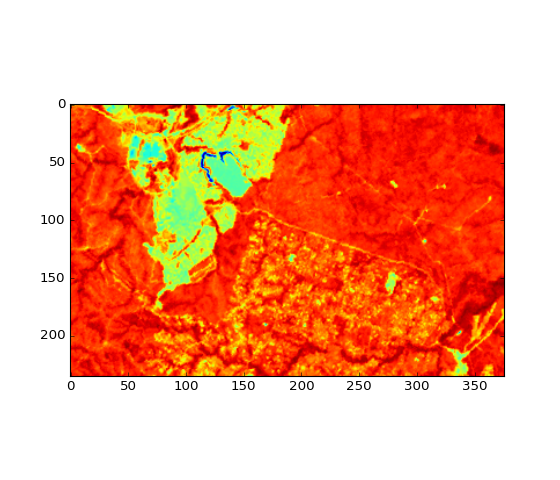

In [53]:
#Click on this image to chose the location for the Hovmoller extraction
w = widgets.HTML("Event information appears here when you click on the figure")


def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize =(7,6))
plt.imshow(annual_mean.sel(year = 2016))

fig.canvas.mpl_connect('button_press_event', callback)
#plt.title(2016)
plt.show()
display(w)

In [71]:
x, y

(256, 164)

<IPython.core.display.Javascript object>


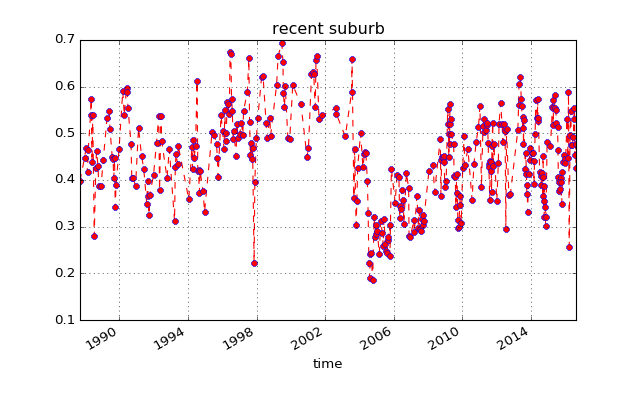

In [72]:
#Use this plot to visualise NDVI and NDBI time series
fig = plt.figure(figsize=(8,5))
ndvi.isel(x=[x],y=[y]).dropna('time', how = 'any').plot(linestyle= '--', c= 'r', marker = '8', mec = 'b', mfc ='r')
plt.title('recent suburb')
plt.grid()

As can be seen in the plot above (assuming you've clicked on a suburb that's been built since 1987), there's a large drop in NDVI, and especially the maximum NDVI values.  The example below shows how to use the maximum annual NDVI values to identify areas that have been turned into suburbs.

In [56]:
#Calculate the standard deviation in NDVI per year
ndvi_annual_max = ndvi.groupby('time.year').max(dim = 'time')

### Export the delta image to netCDF to enable importing into QGIS, Arc etc

<IPython.core.display.Javascript object>


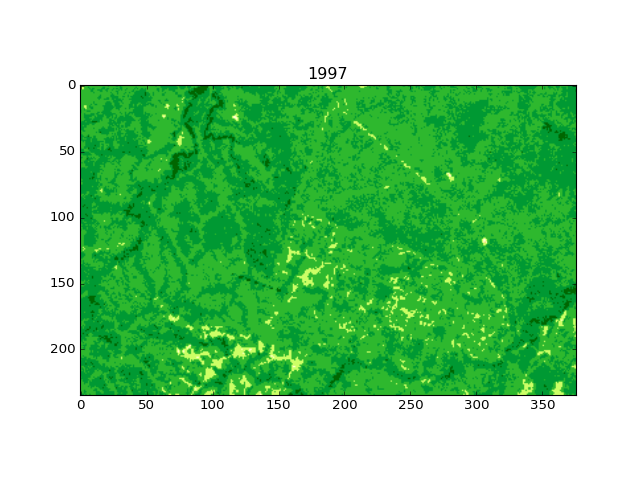

In [67]:
#This controls the colour maps used for plotting NDVI, TSS and Normalised Burn Ratio
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds_sub = [-1, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds_sub, ndvi_cmap.N)

fig = plt.figure()
change_year = 1997

plt.imshow(ndvi_annual_max.sel(year = change_year), cmap = ndvi_cmap, norm = ndvi_norm)
plt.title(change_year)

<IPython.core.display.Javascript object>


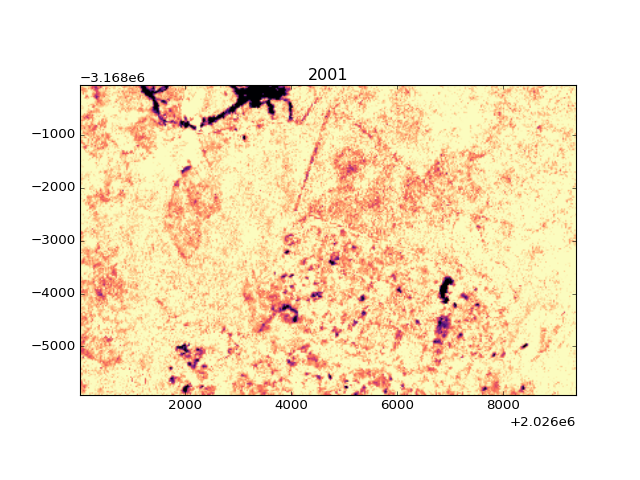

In [77]:
#Calculate the difference between in maximum NDVI between a change year, and a reference year (2 years prior)
#2 years are used to account for changes that may have started part way through the previous year.
#Yellow tones indicate little-no change in maximum NDVI between years, oranges indicate a decrease and purples indicate
# a large decrease

fig = plt.figure()
#Define the year you wish to use to detect change
change_year = 2001
#Define the year you wish to use as a reference point
ref_year = (change_year - 2)

max_ref_year = ndvi_annual_max.sel(year = (ref_year))
max_change_year =ndvi_annual_max.sel(year = (change_year))
max_dif = max_change_year - max_ref_year
plt.imshow(max_dif, cmap = 'magma', vmin = -0.3, vmax = 0, extent=[max_dif.coords['x'].min(), max_dif.coords['x'].max(), 
                   max_dif.coords['y'].min(), max_dif.coords['y'].max()])
plt.title(change_year)


In [ ]:
#Convert the data array into a dataset so that netCDF has the necessary variable names
max_dif_ds = max_dif.to_dataset(name = 'ndvi_max_delta')
# add the coordinate reference system (crs) back into the attributes
max_dif_ds.attrs['crs'] = crs
# write the netCDF file out
write_dataset_to_netcdf(max_dif_ds, '/g/data/r78/lxl554/ndvi_max_delta_from_'+str(change_year)+'to'+str(ref_year)+'.nc')